# Physical matrix retrieval from simulated data

### Imports and data loading

Load the libraries

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import speckleret as spr

data_path = 'C:/ML/datasets/synth_dset_grin_Nmodes=113_degen=True_len=500_mirr=36.mat'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

In [12]:
fields = loadmat(data_path)['fields']
weights = loadmat(data_path)['macropixels_energy']
transfer_matrix = loadmat(data_path)['transfer_matrix']
tm_ref = transfer_matrix * np.exp(-1j * np.angle(transfer_matrix[0, ...]))
maps = loadmat(data_path)['phase_maps']

### Phase retrieval

In [279]:
idx_list = []
support_list = []
retrieved_list = []
results_list = []
restarts_list = []
N = 10
Q_trsh = 0.99
max_restart = 10

for i in range(N):
    # Draw a random index
    idx = np.random.randint(0, fields.shape[2])

    # Prepare FT
    field = fields[:, :, idx]
    field = field / np.sqrt(np.sum(np.square(np.abs(field))))
    ft = spr.transforms.fourier_transform(field)
    ft = ft / np.sqrt(np.sum(np.square(np.abs(ft))))

    # Define support
    support = spr.supports.disk_support(field, radius=65)
    # support = spr.supports.threshold_support(field, threshold=0.005)

    Q = 0
    counter = -1
    while Q < Q_trsh:
        # Retrieve phase
        x, results = spr.retrievalmath.run(
                magnitudes=(np.abs(field), np.abs(ft)),
                support=support,
                init=spr.initializers.random_phases(magnitude=np.abs(field)),
                target_field=field,
                algorithm=spr.retrievalmath.RAAR,
                algorithm_kwargs={'beta': 0.7},
                max_iter=50,
                rel_tol=1e-6,
                )
        Q = 1 - results['quality'][-1]
        counter += 1
        if counter == max_restart:
            print(f"Draw {i + 1} / {N} did not converge!")
            break

    print(f"{i + 1} / {N}, Q = {Q}")
    if counter == max_restart:
        continue

    idx_list.append(idx)
    support_list.append(support)
    restarts_list.append(counter)
    results_list.append(results)
    retrieved_list.append(x)
    

Draw 1 / 10 did not converge!
1 / 10, Q = 0.24718471147276067
2 / 10, Q = 0.998281905152717
3 / 10, Q = 0.9999874465458147
4 / 10, Q = 0.9947873367289014
5 / 10, Q = 0.9983707138532648
6 / 10, Q = 0.9999508411037309
7 / 10, Q = 0.999987513567942
Draw 8 / 10 did not converge!
8 / 10, Q = 0.3971372657038723
9 / 10, Q = 0.9999932735362302
10 / 10, Q = 0.9986463240347256


Check results

In [280]:
Q_list = [1 - results_list[i]['quality'][-1] for i in range(len(results_list))]
print(f"Indexes: {idx_list}")
print(f"Restarts: {restarts_list}")
print(f"Quality: {Q_list}")

Indexes: [23, 363, 297, 316, 124, 456, 168, 10]
Restarts: [0, 1, 0, 0, 0, 4, 3, 0]
Quality: [0.998281905152717, 0.9999874465458147, 0.9947873367289014, 0.9983707138532648, 0.9999508411037309, 0.999987513567942, 0.9999932735362302, 0.9986463240347256]


### Matrix checks

(36, 65536) (36,) (256, 256)


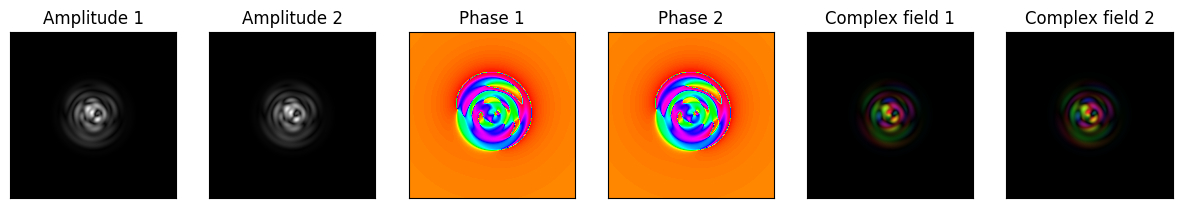

In [281]:
idx = np.random.randint(0, len(idx_list))

tm = transfer_matrix.reshape((transfer_matrix.shape[0], np.prod(transfer_matrix.shape[1:])))
x_in = (np.sqrt(weights) * np.exp(1j * maps[..., idx_list[idx]])).reshape(np.prod(weights.shape))
y_out = (tm.T @ x_in).reshape(transfer_matrix.shape[1:])
print(tm.shape, x_in.shape, y_out.shape)

_ = spr.plots.compare_complex_fields(fields[..., idx_list[idx]], y_out, remove_ticks=True)

### Matrix reconstruction

Let's do the difference product

Text(0.5, 1.0, 'Average correction')

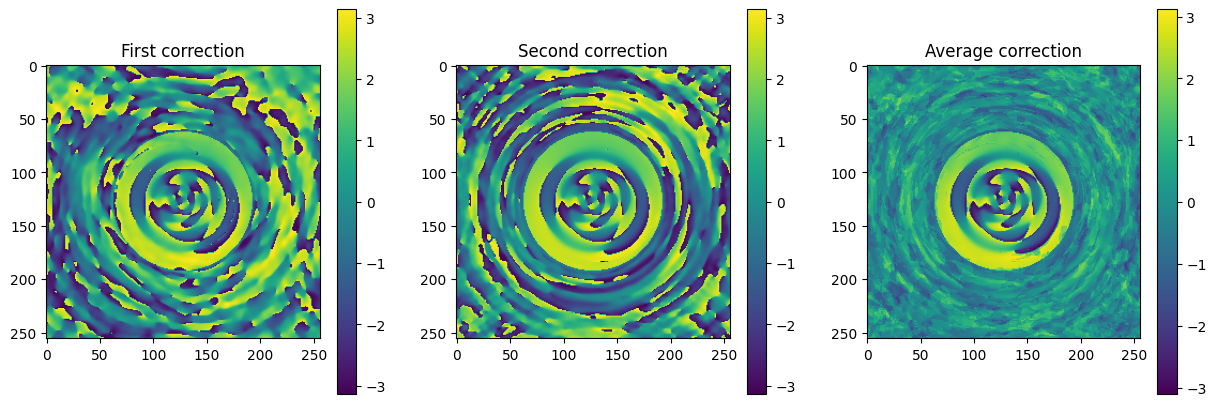

In [346]:
tm_ref = tm_ref.reshape((transfer_matrix.shape[0], np.prod(transfer_matrix.shape[1:])))

corrections = np.zeros(shape=(len(retrieved_list), *transfer_matrix.shape[1:]), dtype=complex)
for i in range(len(retrieved_list)):
    x_in = (np.sqrt(weights) * np.exp(1j * maps[..., idx_list[i]])).reshape(np.prod(weights.shape))
    y_from_tm_ref = (tm_ref.T @ x_in).reshape(transfer_matrix.shape[1:])
    correction = np.exp(1j * np.angle(retrieved_list[i])) * np.exp(-1j * np.angle(y_from_tm_ref))
    correction = np.exp(1j * (np.angle(correction) - np.angle(correction[128, 128])))
    corrections[i, :, :] = correction


correction_avg = np.exp(1j * np.mean(np.angle(corrections[:, :, :]), axis=0))
# phi_rand = np.random.rand(np.sum(np.logical_not(support_list[0])))
# correction_avg[np.logical_not(support_list[0])] = np.exp(1j * 2 * np.pi * phi_rand)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
pl0 = axs[0].imshow(np.angle(corrections[0, ...]))
plt.colorbar(pl0, ax=axs[0])
axs[0].set_title("First correction")
pl1 = axs[1].imshow(np.angle(corrections[1, ...]))
plt.colorbar(pl1, ax=axs[1])
axs[1].set_title("Second correction")
pl2 = axs[2].imshow(np.angle(correction_avg))
plt.colorbar(pl2, ax=axs[2])
axs[2].set_title("Average correction")

Phase error:
  - Mean: 0.69298 rad
  - Std: 1.01149 rad


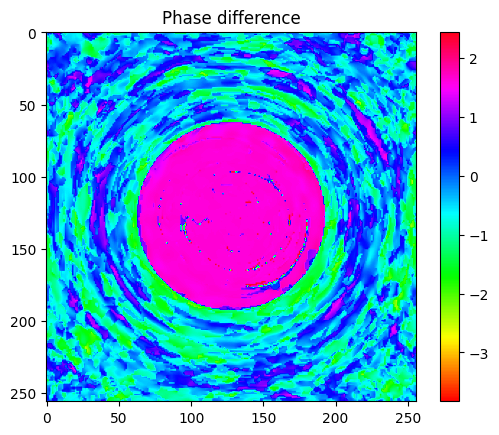

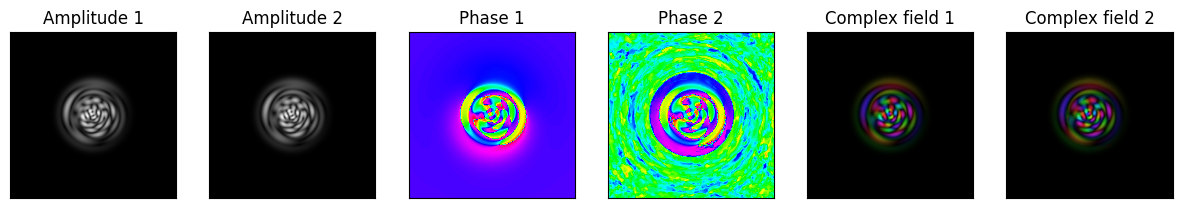

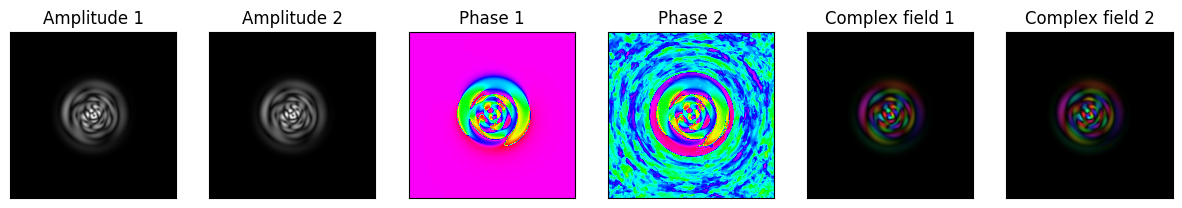

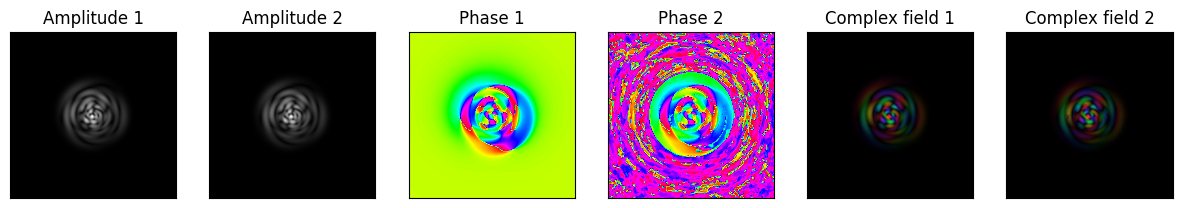

In [321]:
_ = spr.plots.phase_difference(correction_avg, transfer_matrix[0, ...])
tm_dref = tm_ref.reshape(transfer_matrix.shape) * correction_avg

for i in range(3):
    _ = spr.plots.compare_complex_fields(transfer_matrix[i, ...], tm_dref[i, ...], remove_ticks=True)

### Final check

Show an example

Quality: 0.9702618324739191
Phase error:
  - Mean: -2.26982 rad
  - Std: 0.38545 rad


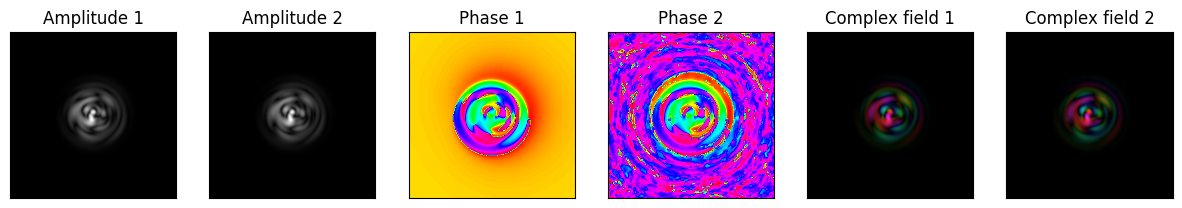

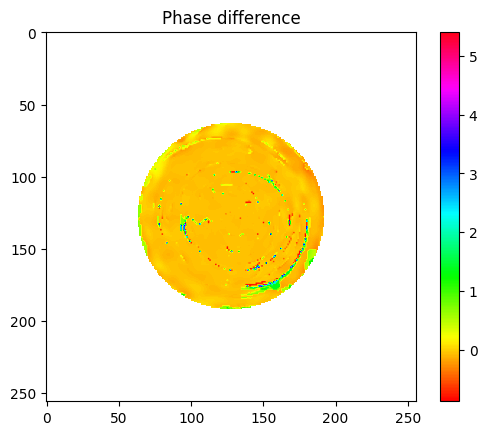

In [341]:
tm = transfer_matrix.reshape((transfer_matrix.shape[0], np.prod(transfer_matrix.shape[1:])))
tm_ret = tm_dref.reshape(tm.shape)

idx = np.random.randint(0, len(idx_list))

x_in = (np.sqrt(weights) * np.exp(1j * maps[..., idx])).reshape(np.prod(weights.shape))
y_out = (tm.T @ x_in).reshape(transfer_matrix.shape[1:])
y_out_ret = (tm_ret.T @ x_in).reshape(transfer_matrix.shape[1:])
support_disp = spr.supports.disk_support(y_out, radius=65)

print(f"Quality: {spr.metrics.quality(fields[..., idx], y_out_ret)}")
_ = spr.plots.compare_complex_fields(y_out, y_out_ret, remove_ticks=True)

y_out[np.logical_not(support_disp)] = np.nan
y_out_ret[np.logical_not(support_disp)] = np.nan
_ = spr.plots.phase_difference(y_out, y_out_ret)

Do statistics on an available field

In [342]:
Q_out = np.zeros(fields.shape[-1])
Q_out_support = np.zeros(fields.shape[-1])
phi
for idx in range(fields.shape[-1]):
    x_in = (np.sqrt(weights) * np.exp(1j * maps[..., idx])).reshape(np.prod(weights.shape))
    y_out = (tm.T @ x_in).reshape(transfer_matrix.shape[1:])
    y_out_ret = (tm_ret.T @ x_in).reshape(transfer_matrix.shape[1:])
    support_disp = spr.supports.disk_support(y_out, radius=65)

    Q_out[idx] = spr.metrics.quality(fields[..., idx], y_out_ret)
    Q_out_support[idx] = spr.metrics.quality(fields[..., idx][support], y_out_ret[support])

In [ ]:
print(np.std(fields[..., idx][support], y_out_ret[support]))

Plot histogram

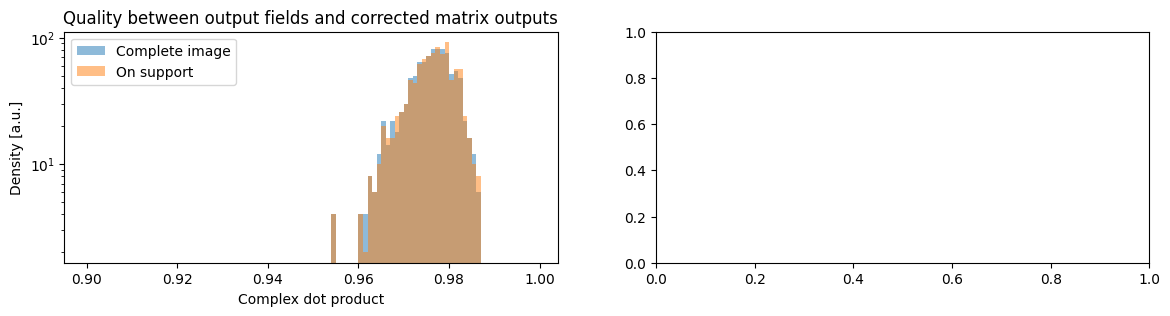

In [343]:
bins1 = np.arange(0.9, 1, 0.001)
density = True

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].hist(Q_out.flatten(), density=density, bins=bins1, ls='None', alpha=0.5, label='Complete image')
axs[0].hist(Q_out_support.flatten(), density=density, bins=bins1, ls='None', alpha=0.5, label='On support')
axs[0].set_title("Quality between output fields and corrected matrix outputs")
axs[0].set_xlabel("Complex dot product")
axs[0].set_ylabel("Density [a.u.]")
axs[0].set_yscale('log')
axs[0].legend()